In [209]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

from tqdm import trange
import networkx as nx
import math
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


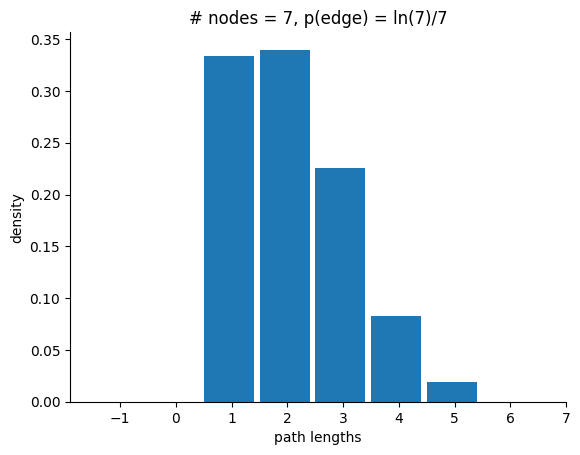

In [753]:
# check distributon of random graph path lengths
n_iters = 1000
path_lengths = []
n_edges = []
n_nodes = 7
p = math.log(n_nodes)/n_nodes

for _iter in range(n_iters):
    g = nx.connected_watts_strogatz_graph(n_nodes, k=2 , p=p)
    n_edges.append(len(g.edges))
    for n1 in g.nodes:
        for n2 in g.nodes:
            if n1 != n2:
                try:
                    path_lengths.append(nx.shortest_path_length(g, n1, n2))
                except nx.NetworkXNoPath:
                    path_lengths.append(-1)
plt.hist(path_lengths, bins=range(-1, n_nodes+1), density=True, align='left', width=0.9)
plt.xticks(range(-1, n_nodes+1))
plt.xlabel("path lengths")
plt.ylabel("density")
plt.title("# nodes = {n_nodes}, p(edge) = ln({n_nodes})/{n_nodes}".format(n_nodes=n_nodes))
sns.despine()

plt.show()

In [755]:
def edge_to_str(edge):
    return chr(edge[0] + ord('a')) + chr(edge[1] + ord('a')) + "."

def edge_context(edges):
    return "".join([edge_to_str(edge) for edge in edges])

def query(n1, n2):
    return chr(n1 + ord('a')) + chr(n2 + ord('a')) + "?"

def max_question_length(n_nodes):
    return len(generate_question(nx.connected_watts_strogatz_graph(n_nodes, k=2, p=0))[0])

def generate_question(G, n1=None, n2=None):
    assert n1 is None or n1 in G.nodes, "n1 is not a node in the graph"
    assert n2 is None or n2 in G.nodes, "n2 is not a node in the graph"
    
    if n1 is None and n2 is None:
        n1, n2 = np.random.choice(list(G.nodes), replace=False, size=2)
    else:
        assert n1 != n2, "n1 and n2 are the same node"
        if n1 is None:
            n1 = np.random.choice(list(G.nodes))
        if n2 is None:
            n2 = np.random.choice(list(G.nodes))
    try: 
        answer = nx.shortest_path_length(G, n1, n2)
    except nx.NetworkXNoPath:
        answer = -1
        
    edges = np.random.permutation([np.random.permutation(e) for e in list(G.edges)])
    return edge_context(edges) + query(n1, n2), answer

def create_token_map(n_nodes):
    token_map = {}
    for i in range(n_nodes):
        token_map[i] = i
    for i in range(n_nodes):
        token_map[chr(i + ord('a'))] = i + n_nodes 

    token_map["."] = 2*n_nodes
    token_map["-"] = 2*n_nodes + 1
    token_map["?"] = 2*n_nodes + 2
    token_map["pad"] = 2*n_nodes + 3
    token_map[-1] = 2*n_nodes + 4
    return token_map

def tokenize(input_str, token_map):
    return torch.tensor([token_map[c] for c in input_str])


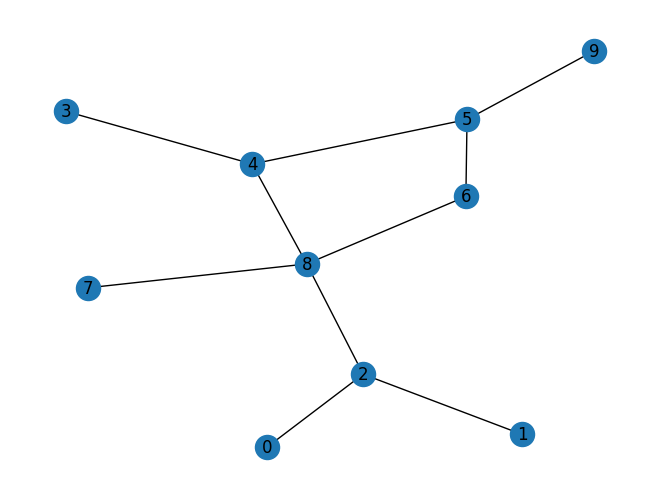

In [778]:
g = nx.connected_watts_strogatz_graph(10, k=2, p=0.4)
nx.draw(g, with_labels=True)

In [779]:
from torch.utils.data import Dataset, DataLoader

class graphDataset(Dataset):
    def __init__(self, n_nodes, p, n_graphs, train_test_split=0.75):
        self.n_nodes = n_nodes
        self.p = p        
        self.train_test_split = train_test_split
        self.token_map = create_token_map(n_nodes)
        self.n_tokens = len(self.token_map)
        self.max_length = max_question_length(n_nodes)
        
        self.X = torch.zeros(n_graphs, self.max_length, dtype=torch.long)
        self.y = torch.zeros(n_graphs, dtype=torch.long)

        for i in range(n_graphs):
            g = nx.connected_watts_strogatz_graph(self.n_nodes, k=2, p=0.4)
            self.X[i], self.y[i] = self._generate_question_(g)

        self.n_samples = n_graphs
        self.n_train = int(self.n_samples*self.train_test_split)
        self.train_idx = torch.arange(self.n_train)

        self.test_idx = torch.arange(self.n_train, self.n_samples)
        self.n_test = len(self.test_idx)

    def _generate_question_(self, G, n1=None, n2=None):
            q, a = generate_question(G, n1, n2)
            n_pad = self.max_length - len(q)
            padding = torch.tensor([self.token_map["pad"]]*n_pad)
            q, a = torch.cat((padding, tokenize(q, self.token_map))), torch.tensor(self.token_map[a])
            return (q, a)
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        return 
    
    def generate_batch(self, batch_size, type='train', task=None):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        assert type in ['train', 'test'], "type must be either 'train' or 'test'"
        if type == 'train':
            idx = self.train_idx[torch.randint(0, self.n_train, (batch_size,))]
        else:
            idx = self.test_idx[torch.randint(0, self.n_test, (batch_size,))]
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [780]:
data = graphDataset(5, p, 50000)

In [ ]:
complexModel = rollout.models.FlexibleTransformer(d_model = 256, n_tokens = data.n_tokens, max_positions = data.max_length, n_heads = 8, n_attn_layers = 4)
optim = torch.optim.Adam(complexModel.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
c_train_losses, c_test_losses = rollout.models.optimize_model(complexModel, criterion, optim, data, 10000, 500)

Epoch 0: Train Loss: 3.9364407062530518, Test Loss: 1.3273108005523682


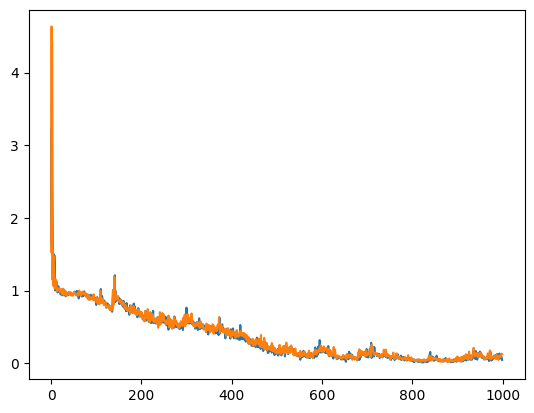

In [733]:
plt.plot(c_train_losses)
plt.plot(c_test_losses)

In [734]:
X, y = data.generate_batch(1000, type='test')

In [740]:
(data.y == 1).float().mean()

tensor(0.4993)

In [736]:
(torch.argmax(complexModel(X), axis=1) == y).float().mean()

tensor(0.9610)

In [742]:
g = nx.connected_watts_strogatz_graph(5, k=2, p=0.4)
inverse_map = {v: k for k, v in token_map.items()}

In [534]:
def change_edge(g, old_edge, new_edge):
    g.remove_edge(*old_edge)
    g.add_edge(*new_edge)
    return g

In [743]:
q0, a0= data._generate_question_(g, 0, 1)
q1, a1 = data._generate_question_(g, 0, 2)

logits, attn0 = complexModel.forward_with_weights(q0.unsqueeze(0))
logits, attn1 = complexModel.forward_with_weights(q1.unsqueeze(0))

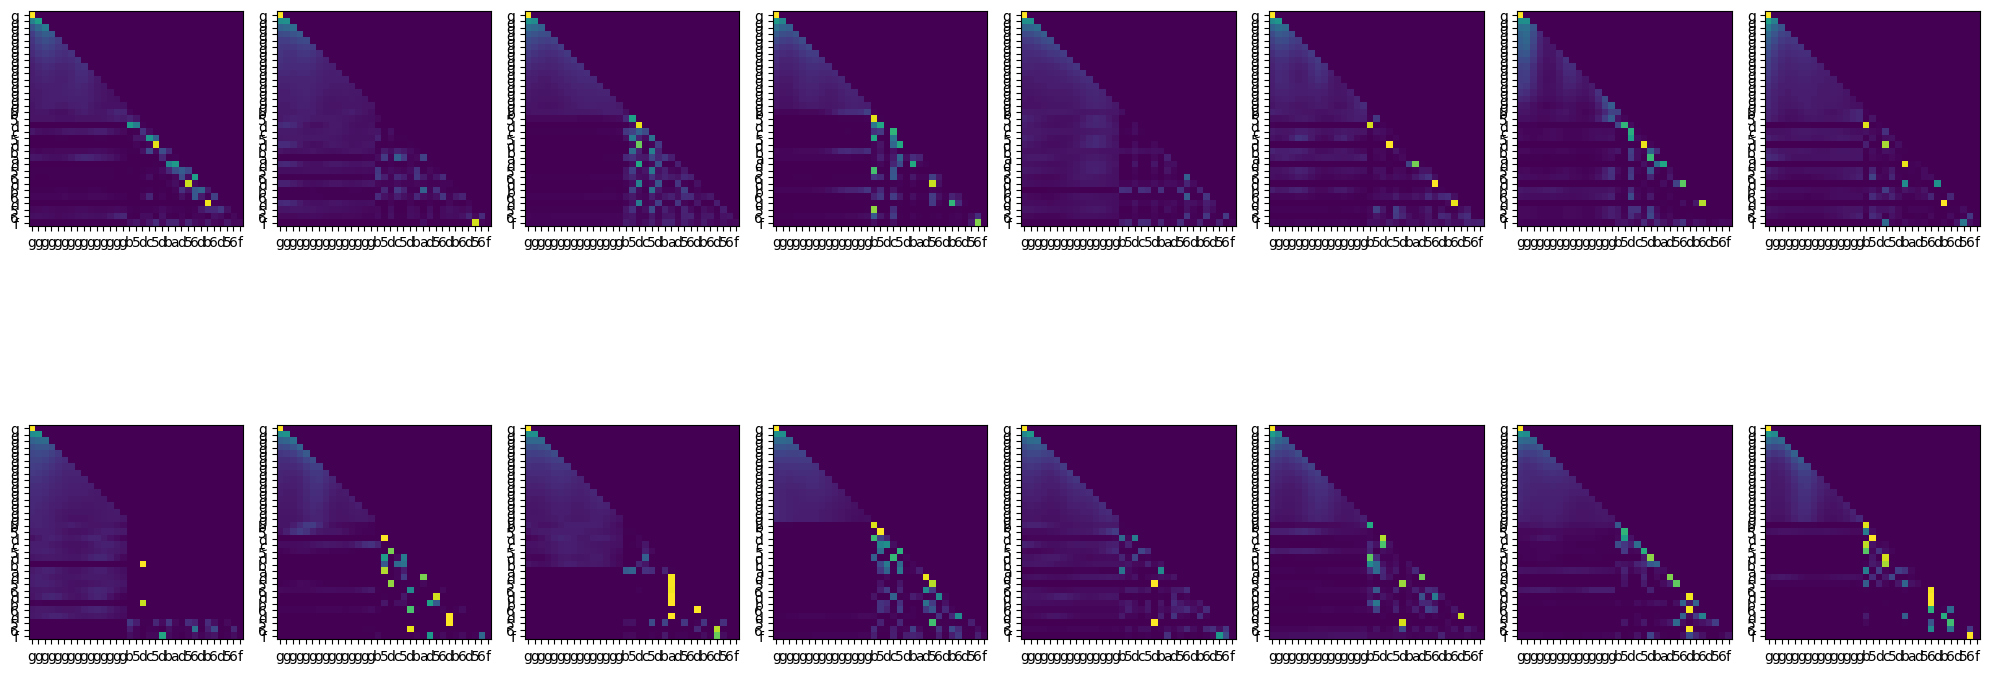

In [746]:
def plot_attn_all(q):
    logits, attn = complexModel.forward_with_weights(q.unsqueeze(0))
    fig, ax = plt.subplots(2, 8, figsize=(20, 10), tight_layout=True)
    n_entries = (len(q) - (q != 17).sum()).detach().numpy()
    q_str = [inverse_map[i] for i in q.detach().numpy()][n_entries:]
    ticks = range(data.max_length - n_entries)
    for j in range(2):
        for i in range(8):
            attn_0 = attn[j].squeeze(0)[i].detach().numpy()
            ax[j, i].imshow(attn_0[n_entries:, n_entries:], cmap='viridis', vmin=0, vmax=1)
            ax[j, i].set_xticks(ticks , q_str)
            ax[j, i].set_yticks(ticks, q_str)
    plt.show()
    
plot_attn_all(q0)

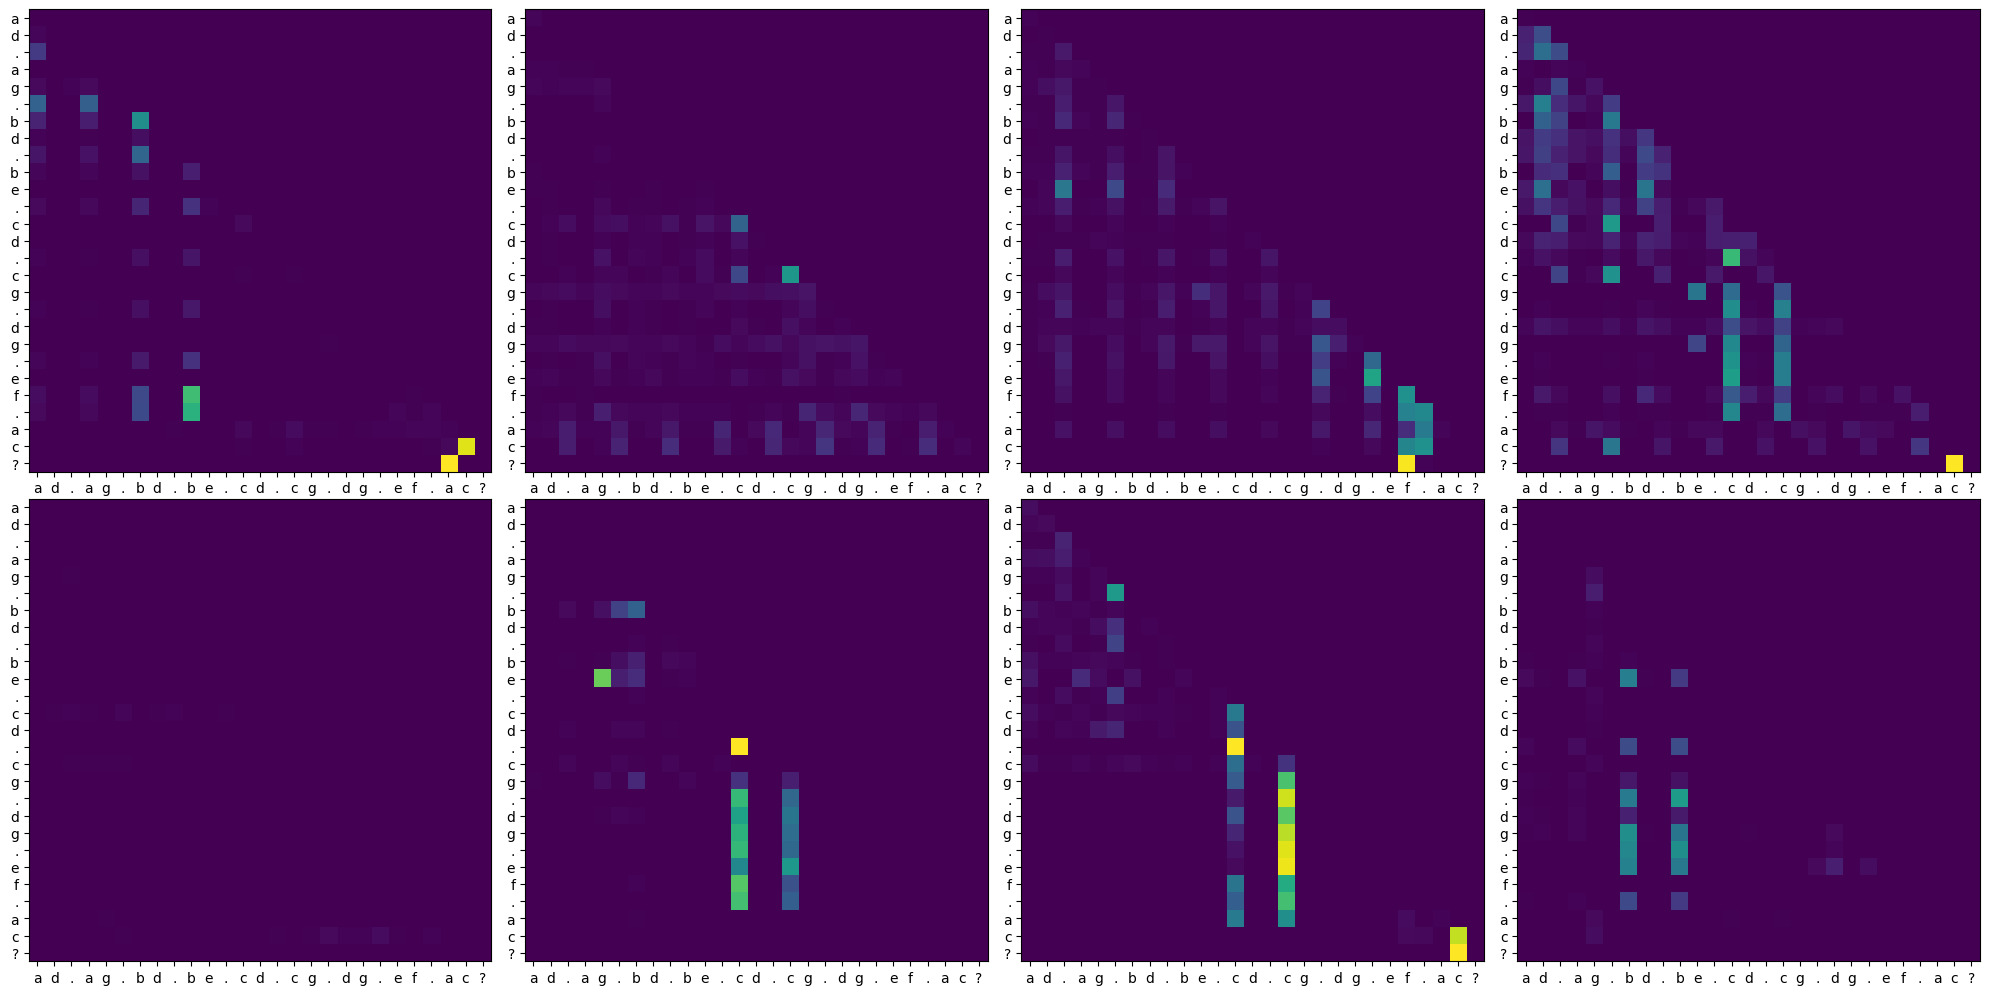

In [549]:
plot_attn_all(q1)

In [624]:
attn_patterns_ = []
qs_ = []
as_ = []
for i in range(7):
    for j in range(7):
        if i != j:
            q, a = data._generate_question_(g, i, j)
            logits, attn = complexModel.forward_with_weights(q.unsqueeze(0))
            attn_patterns_.append(attn)
            qs_.append(q)
            as_.append(a)

In [625]:
n_patterns = len(attn_patterns_)

In [626]:
attn_patterns_[0][0].shape

torch.Size([1, 4, 66, 66])

In [627]:
attn_std = np.zeros([n_patterns, 4, 66, 66])
for i in range(n_patterns):
    attn_std[i, ...] = attn_patterns_[i][0].detach().numpy()

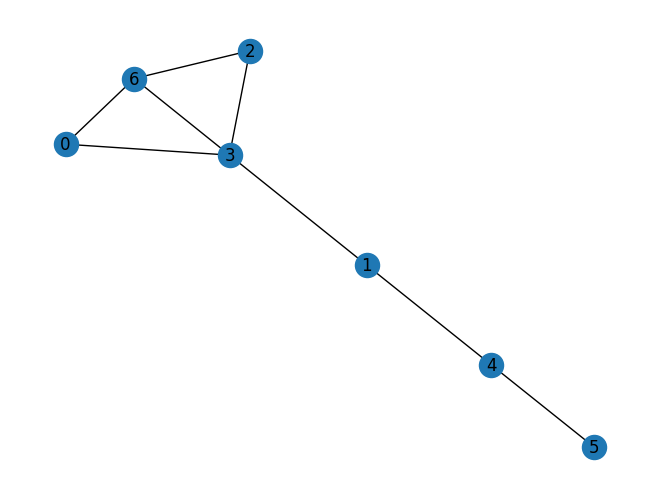

In [628]:
nx.draw(g, with_labels=True)

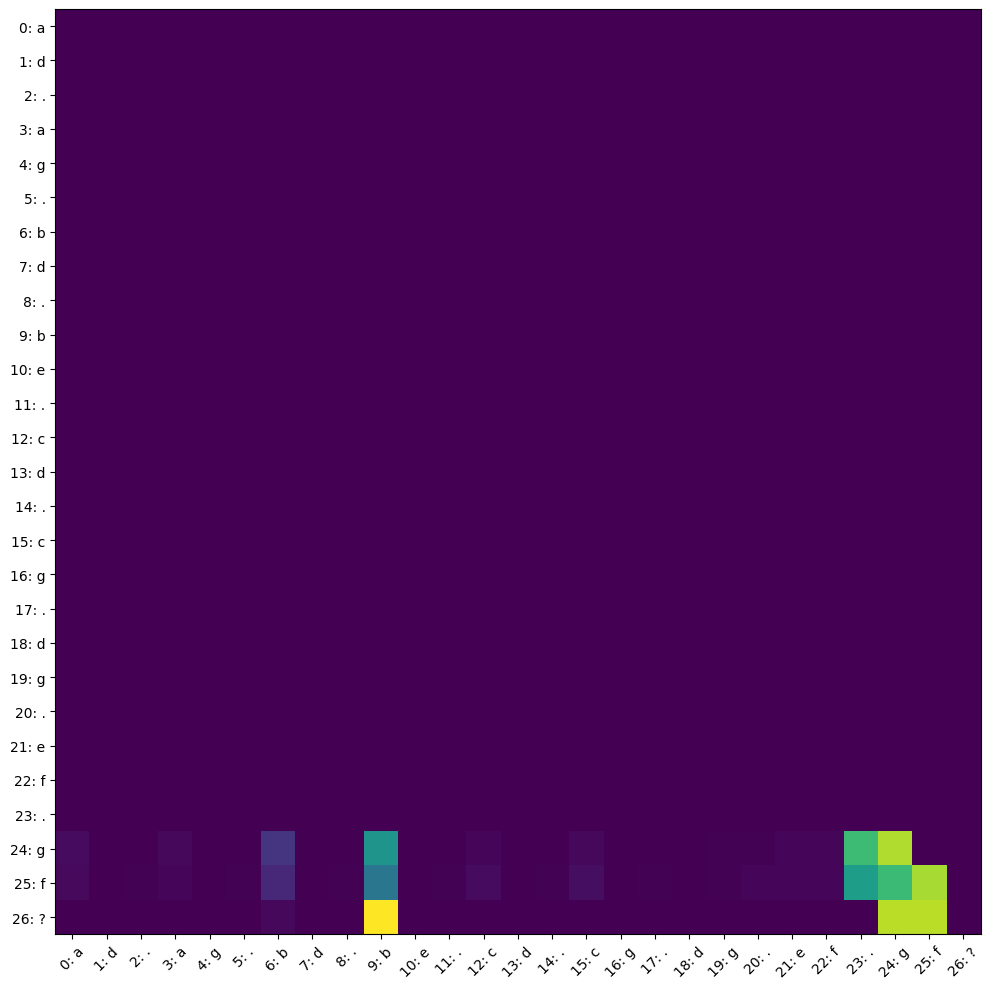

In [680]:
n_entries = (len(q) - (q != 17).sum()).detach().numpy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)
q_str = [str(i - n_entries) + ": " + inverse_map[j] for (i, j) in enumerate(q.detach().numpy())][n_entries:]
plt.imshow(attn_std[:, 0, n_entries:, n_entries:].std(axis=0))
plt.xticks(range(data.max_length - n_entries), q_str, rotation=45)
#plt.xticks(range(data.max_length - n_entries))
plt.yticks(range(data.max_length - n_entries), q_str)
plt.show()

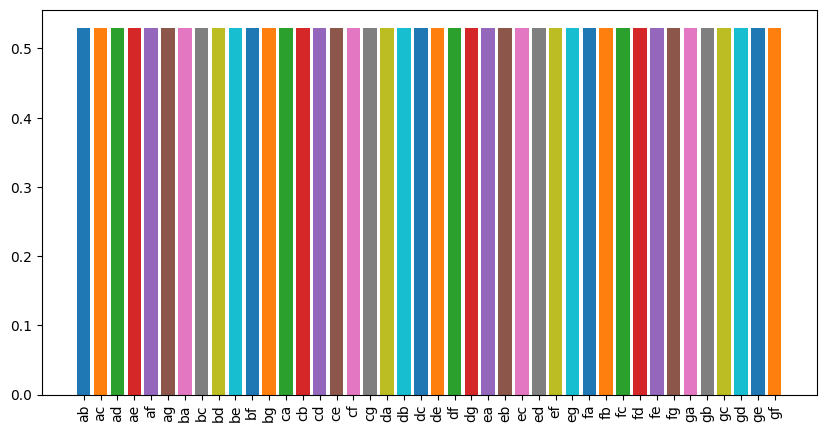

In [677]:
tick = []
fig, ax = plt.subplots(1, figsize=(10, 5))
for i in range(n_patterns):
    plt.bar(i, attn_std[i][1][n_entries + 15, n_entries + 15])
    tick.append("".join([inverse_map[a] for a in qs_[i].detach().numpy()[-3:-1]]))
plt.xticks(np.arange(n_patterns), tick, rotation=90)
plt.show()